In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

path_to_csv = "./IA1_train.csv"
originalData = pd.read_csv(path_to_csv)

## Data preprocessing

1. Add dummy feature for constant
2. Compute age_since_renovated
3. Normalize data

In [123]:
dateformat = originalData["date"].str.split("/", expand = True)
originalData['year'] = dateformat[2].astype(int)
originalData['W0'] = 1
originalData['age_since_renovated'] = np.where(originalData['yr_renovated'] == 0, originalData['year'] - originalData['yr_built'], originalData['year'] - originalData['yr_renovated'])

normalizeData = (originalData - originalData.mean()) / originalData.std()
normalizeData['W0'] = originalData['W0']
normalizeData['waterfront'] = originalData['waterfront']
normalizeData['price'] = originalData['price']

trainingData = normalizeData.drop(['date', 'id'], axis = 1)
trainingData.head()

,W0,age_since_renovated,bathrooms,bedrooms,condition,floors,grade,lat,long,price,...,sqft_living,sqft_living15,sqft_lot,sqft_lot15,view,waterfront,year,yr_built,yr_renovated,zipcode
0,1,0.587803,-1.465613,-0.388520,-0.634184,-0.922332,-0.563015,-0.308988,-0.932779,2.1800,...,-1.159110,-1.018504,-0.171139,-0.185644,-0.304487,0,-0.682211,-0.509385,-0.204437,0.512279
1,1,0.137857,0.169158,-0.388520,0.888924,0.917732,0.290361,-1.816632,-1.179633,2.5025,...,0.145003,0.004058,-0.168133,-0.162508,-0.304487,0,-0.682211,-0.068396,-0.204437,-1.040633
2,1,-1.004315,0.496112,0.649956,-0.634184,0.917732,0.290361,-1.521596,0.428443,2.7000,...,0.298428,1.494077,-0.219787,-0.238313,-0.304487,0,1.465639,1.084961,-0.204437,-0.685148
3,1,2.283754,-0.811705,-0.388520,-0.634184,0.917732,0.290361,0.540053,-1.017415,9.2630,...,-0.457738,-0.434182,-0.244481,-0.298603,-0.304487,0,-0.682211,-2.171576,-0.204437,0.755506
4,1,-0.554368,0.496112,-0.388520,0.888924,0.917732,1.997115,0.943294,0.781091,7.0000,...,0.364182,0.471515,-0.122419,-0.155295,-0.304487,0,-0.682211,0.610049,-0.204437,-0.498050


## Part 1

In [124]:
initial_guess = np.repeat([0.5],21)
featureData = trainingData.drop(['price'], axis = 1)
def BatchGradientDescentRecurse(featureDataframe, actualValue, initialGuess, maxSteps, iteration, minErr, learningRate, returnDict):
    dfSize = len(featureDataframe)
    gradientLw = (2/dfSize)*featureDataframe.mul((featureDataframe.mul(initialGuess).sum(axis=1) - actualValue), axis = 0).sum().values
    normGradient = np.linalg.norm(gradientLw)
    nextW = initialGuess - learningRate*gradientLw
    updateReturn = {'w': initialGuess, 'gradientLw': normGradient, 'n': iteration}
    if (normGradient > minErr and not np.isinf(normGradient) and maxSteps >= 0):
        return BatchGradientDescent(featureDataframe, actualValue, nextW, maxSteps, iteration+1, minErr, learningRate, updateReturn)
    return returnDict

def BatchGradientDescent(featureDataframe, actualValue, initialGuess, maxSteps, minErr, learningRate):
    iteration = 0
    dfSize = len(featureDataframe)
    nextW = initialGuess
    gradientLw = (2/dfSize)*featureDataframe.mul((featureDataframe.mul(initialGuess).sum(axis=1) - actualValue), axis = 0).sum().values
    normGradient = np.linalg.norm(gradientLw)
    MeanSquareError = (1/dfSize)*((featureDataframe.mul(nextW).sum(axis=1) - actualValue)**2).sum()
    MSEs = [MeanSquareError]
    while (normGradient > minErr and not np.isinf(normGradient) and iteration < maxSteps):
        nextW = nextW - learningRate*gradientLw
        gradientLw = (2/dfSize)*featureDataframe.mul((featureDataframe.mul(nextW).sum(axis=1) - actualValue), axis = 0).sum().values
        normGradient = np.linalg.norm(gradientLw)
        MeanSquareError = (1/dfSize)*((featureDataframe.mul(nextW).sum(axis=1) - actualValue)**2).sum()
        MSEs.append(MeanSquareError)
        iteration += 1
    
    return {'w': dict(zip(featureDataframe.columns.values, nextW)), 'gradientLw': normGradient, 'n': iteration, 'MSE': MSEs}


In [125]:
Rate0 = BatchGradientDescent(featureData, trainingData['price'], initial_guess, 5000, 0.1, 10)

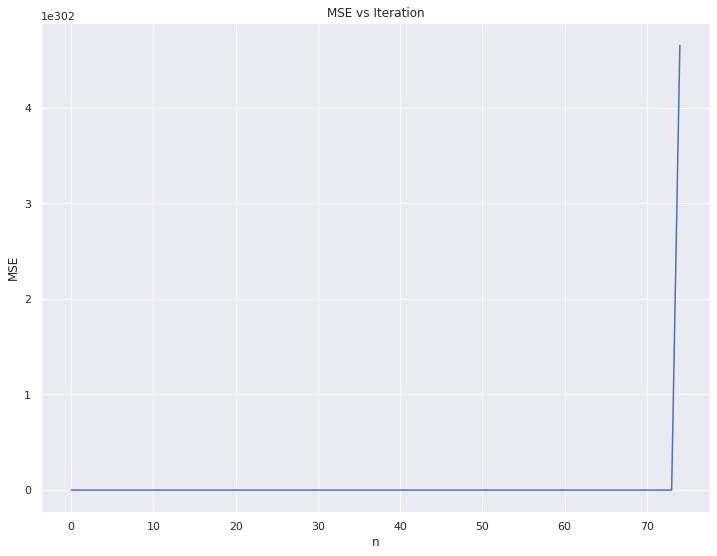

In [126]:
plt.subplots(figsize=(12, 9))
plt.title("MSE vs Iteration")
ax = sns.lineplot(x = list(range(0,Rate0['n']+1)), y = Rate0['MSE'])
ax.set(xlabel='n', ylabel='MSE')
plt.show()

In [127]:
Rate1 = BatchGradientDescent(featureData, trainingData['price'], initial_guess, 5000, 0.1, 0.1)

In [128]:
Rate2 = BatchGradientDescent(featureData, trainingData['price'], initial_guess, 5000, 0.1, 0.01)

In [129]:
Rate3 = BatchGradientDescent(featureData, trainingData['price'], initial_guess, 5000, 0.1, 0.001)

In [130]:
Rate4 = BatchGradientDescent(featureData, trainingData['price'], initial_guess, 5000, 0.1, 0.0001)

In [131]:
Rate5 = BatchGradientDescent(featureData, trainingData['price'], initial_guess, 5000, 0.1, 0.00001)

In [132]:
Rate6 = BatchGradientDescent(featureData, trainingData['price'], initial_guess, 5000, 0.1, 0.000001)

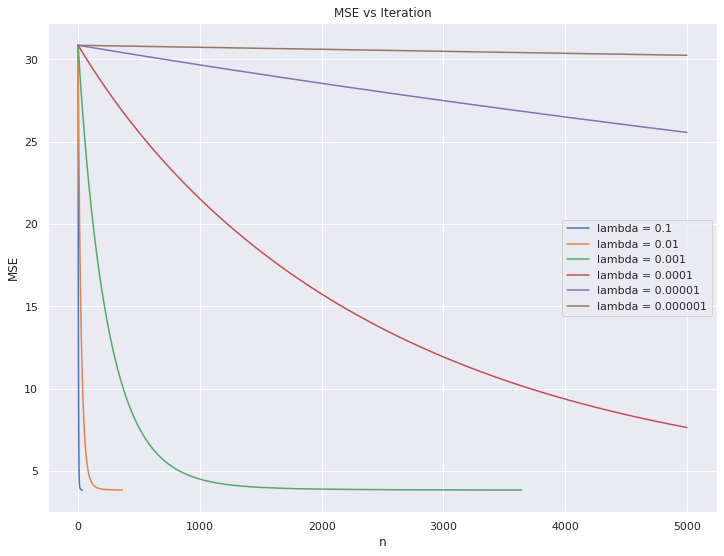

In [133]:
plt.subplots(figsize=(12, 9))
plt.title("MSE vs Iteration")
ax1 = sns.lineplot(x = list(range(0,Rate1['n']+1)), y = Rate1['MSE'], label='lambda = 0.1')
ax2 = sns.lineplot(x = list(range(0,Rate2['n']+1)), y = Rate2['MSE'], label='lambda = 0.01')
ax3 = sns.lineplot(x = list(range(0,Rate3['n']+1)), y = Rate3['MSE'], label='lambda = 0.001')
ax4 = sns.lineplot(x = list(range(0,Rate4['n']+1)), y = Rate4['MSE'], label='lambda = 0.0001')
ax5 = sns.lineplot(x = list(range(0,Rate5['n']+1)), y = Rate5['MSE'], label='lambda = 0.00001')
ax6 = sns.lineplot(x = list(range(0,Rate6['n']+1)), y = Rate6['MSE'], label='lambda = 0.000001')
ax6.set(xlabel='n', ylabel='MSE')
ax6.legend()
plt.show()